# Import Libaries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_score
from scipy.stats.mstats import winsorize

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras_tuner as kt

import shap


# Import data

In [128]:
bs_ratio = pd.read_csv("BS_ratio_df_cleaned.csv")
bs = pd.read_csv("BS_df_cleaned.csv")

pnl_ratio = pd.read_csv("PNL_ratio_df_cleaned.csv")
pnl = pd.read_csv("PNL_df_cleaned.csv")

cf = pd.read_csv("CF_df_cleaned.csv")

cross = pd.read_csv("crossstatement_ratio_df_cleaned.csv")


# Selected features from extant literature

In [129]:
features_in_bs_ratio = ["Cash & Cash Equivalents to Total Assets",
                 "Total Liabilities Percentage of Total Assets", #Note
                 "Current Ratio",
                 "Quick Ratio",
                 "Inventories Percentage of Total Assets", #Note
                 "Inventories Percentage of Total Current Assets", #Note
                 "Date", "Instrument",]

features_in_bs = ["Total Assets", "Total Liabilities",
                    "Total Current Assets", "Total Current Liabilities",
                    "Cash & Cash Equivalents", "Inventories - Total",
                    "Shareholders' Equity - Attributable to Parent ShHold - Total",
                    "Debt - Total", "Total Fixed Assets - Net",
                    "Working Capital - Non-Cash", "Short-Term Debt & Current Portion of Long-Term Debt",
                    "Debt - Long-Term - Total", "Accounts Payable",
                    "Intangible Assets - excluding Goodwill - Net - Total",
                    "Date", "Instrument", "Target"]

features_in_pnl_ratio = ["Operating Margin - %", "Net Margin - %", 
                         "Date", "Instrument"]

features_in_pnl = ["Net Income after Tax","Operating Expenses",
                   "Revenue from Business Activities - Total",
                   "Cost of Operating Revenue", "Sales of Goods & Services - Net",
                   "Normalized Pre-tax Profit",
                   "Selling General & Administrative Expenses - Total",
                   "Date", "Instrument"]

features_in_cf = ["Net Cash Flow from Operating Activities",
                  "Date", "Instrument"]

features_in_cross = ["Inventory Turnover", "Operating Cycle Days", # วันไม่ตรงไม่ใช้ เดี๋ยวสร้างเอง
                     "Reinvestment Rate - %, TTM", # วันไม่ตรงข้อมูลไม่พอ ลบออก
                     "Date", "Instrument"]

In [130]:
bs_ratio = bs_ratio[features_in_bs_ratio]
bs = bs[features_in_bs]
pnl_ratio = pnl_ratio[features_in_pnl_ratio]
pnl = pnl[features_in_pnl]
cf = cf[features_in_cf]
cross = cross[features_in_cross]

In [131]:
print(bs_ratio.shape)
print(bs.shape)
print(pnl_ratio.shape)
print(pnl.shape)
print(cf.shape)
print(cross.shape)

(937, 8)
(937, 17)
(937, 4)
(937, 9)
(937, 3)
(920, 5)


In [132]:
df =  bs_ratio.merge(bs, on=["Date", "Instrument"], how="left") \
        .merge(pnl_ratio, on=["Date", "Instrument"], how="left") \
        .merge(pnl, on=["Date", "Instrument"], how="left") \
        .merge(cf, on=["Date", "Instrument"], how="left") \
        .merge(cross, on=["Date", "Instrument"], how="left")

In [133]:
df.insert(0, "Instrument", df.pop("Instrument"))
df.insert(0, "Date", df.pop("Date"))
df["Target"] = df.pop("Target")

print(df.columns.tolist())

['Date', 'Instrument', 'Cash & Cash Equivalents to Total Assets', 'Total Liabilities Percentage of Total Assets', 'Current Ratio', 'Quick Ratio', 'Inventories Percentage of Total Assets', 'Inventories Percentage of Total Current Assets', 'Total Assets', 'Total Liabilities', 'Total Current Assets', 'Total Current Liabilities', 'Cash & Cash Equivalents', 'Inventories - Total', "Shareholders' Equity - Attributable to Parent ShHold - Total", 'Debt - Total', 'Total Fixed Assets - Net', 'Working Capital - Non-Cash', 'Short-Term Debt & Current Portion of Long-Term Debt', 'Debt - Long-Term - Total', 'Accounts Payable', 'Intangible Assets - excluding Goodwill - Net - Total', 'Operating Margin - %', 'Net Margin - %', 'Net Income after Tax', 'Operating Expenses', 'Revenue from Business Activities - Total', 'Cost of Operating Revenue', 'Sales of Goods & Services - Net', 'Normalized Pre-tax Profit', 'Selling General & Administrative Expenses - Total', 'Net Cash Flow from Operating Activities', 'Inv

In [134]:
df["ln_total_assets"] = np.log(df["Total Assets"])
df["ROA"] = df["Net Income after Tax"] / df["Total Assets"]
df["net_income_to_current_assets"] = df["Net Income after Tax"] / df["Total Current Assets"]
df["operating_expense_to_sales"] = df["Operating Expenses"] / df["Revenue from Business Activities - Total"]
df["gross_profit_margin"] = (df["Revenue from Business Activities - Total"] - df["Cost of Operating Revenue"]) / df["Sales of Goods & Services - Net"]
df["operating_income_margin"] = (df["Revenue from Business Activities - Total"] - df["Cost of Operating Revenue"] - df["Operating Expenses"]) / df["Revenue from Business Activities - Total"]
df["inventory_turnover"] = df["Cost of Operating Revenue"] / df["Inventories - Total"]
df["operating_cashflow_ratio"] = df["Net Cash Flow from Operating Activities"] / df["Total Current Liabilities"]
df["pretax_profit_margin"] = df["Normalized Pre-tax Profit"] / df["Sales of Goods & Services - Net"]
df["ROE"] = df["Net Income after Tax"] / df["Shareholders' Equity - Attributable to Parent ShHold - Total"]
df["fixed_assests_to_total_assets"] = df["Total Fixed Assets - Net"] / df["Total Assets"]
df["working_capital_noncash_to_total_assets"] = df["Working Capital - Non-Cash"] / df["Total Assets"]
df["growth_revenue"] = df["Revenue from Business Activities - Total"].pct_change()
df["growth_ncwc"] = df["Working Capital - Non-Cash"].pct_change()
df["sg&a_to_revenue"] = df["Selling General & Administrative Expenses - Total"] / df["Revenue from Business Activities - Total"]
df["invest_bear_lia_to_equity"] = (df["Short-Term Debt & Current Portion of Long-Term Debt"] + df["Debt - Long-Term - Total"]) / df["Shareholders' Equity - Attributable to Parent ShHold - Total"]
df["APTR"] = df["Accounts Payable"] / df["Cost of Operating Revenue"]
df["GP"] = df["Intangible Assets - excluding Goodwill - Net - Total"] / df["Total Assets"]
df["accural"] = df["Net Income after Tax"] - df["Net Cash Flow from Operating Activities"]

In [135]:
df.shape

(937, 55)

In [136]:
df1 = df.copy()
df1 = df1[["Instrument", "Date", "ln_total_assets", "ROA", 
          "net_income_to_current_assets", "Inventories Percentage of Total Assets",
          "Inventories Percentage of Total Current Assets",
          "Cash & Cash Equivalents to Total Assets",
          "operating_expense_to_sales",
          "gross_profit_margin", "operating_income_margin",
          "Total Liabilities Percentage of Total Assets",
          "Current Ratio", "Quick Ratio",
          "inventory_turnover", "operating_cashflow_ratio",
          "pretax_profit_margin",
          "Net Margin - %",
          "ROE", "fixed_assests_to_total_assets",
          "working_capital_noncash_to_total_assets",
          "growth_revenue", "growth_ncwc", "sg&a_to_revenue",
          "invest_bear_lia_to_equity", "APTR", "GP", "accural",
          "Target"]]

In [137]:
df1

,Instrument,Date,ln_total_assets,ROA,net_income_to_current_assets,Inventories Percentage of Total Assets,Inventories Percentage of Total Current Assets,Cash & Cash Equivalents to Total Assets,operating_expense_to_sales,gross_profit_margin,...,fixed_assests_to_total_assets,working_capital_noncash_to_total_assets,growth_revenue,growth_ncwc,sg&a_to_revenue,invest_bear_lia_to_equity,APTR,GP,accural,Target
0,KC.BK,2024-12-31,20.688713,-0.140323,-0.322647,12.207070,28.067940,0.034570,2.196268,0.181340,...,0.545830,-0.243287,NaN,NaN,1.498429,2.874472,7.686882,0.000782,-5.546642e+07,1
1,KC.BK,2023-12-31,20.771775,-0.062691,-0.117267,12.999080,24.315370,0.141950,1.201147,0.225256,...,0.465397,-0.181403,2.851140,-0.189787,0.479573,1.720723,2.109145,0.000895,-1.131291e+08,1
2,KC.BK,2022-12-31,20.692272,-0.091602,-0.139587,22.042970,33.590290,0.150890,1.267552,0.255361,...,0.343770,-0.078953,-0.012436,-0.598029,0.597820,1.881897,2.222047,0.001160,-6.578326e+07,1
3,KC.BK,2021-12-31,20.732728,-0.074965,-0.100216,27.616430,36.918660,0.194820,1.573818,0.259974,...,0.251966,-0.030312,-0.457033,-0.600218,0.924566,1.277861,4.117928,0.000256,1.430306e+07,1
4,KC.BK,2020-12-31,20.546625,-0.123026,-0.182602,31.498170,46.751590,0.023080,1.506129,0.257600,...,0.326265,-0.082904,0.377911,1.270568,0.810170,2.691778,2.978975,0.000421,-2.688464e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,TPCHm.BK,2009-12-31,22.540462,0.049401,0.237580,0.415156,2.436355,0.069801,0.741328,0.335385,...,0.790566,-0.025015,0.000000,0.000000,0.085434,1.148782,0.088308,0.001074,-1.242425e+08,0
933,TPCHm.BK,2008-12-31,22.540462,0.049401,0.237580,0.415156,2.436355,0.069801,0.741328,0.335385,...,0.790566,-0.025015,0.000000,0.000000,0.085434,1.148782,0.088308,0.001074,-1.242425e+08,0
934,TPCHm.BK,2007-12-31,22.540462,0.049401,0.237580,0.415156,2.436355,0.069801,0.741328,0.335385,...,0.790566,-0.025015,0.000000,0.000000,0.085434,1.148782,0.088308,0.001074,-1.242425e+08,0
935,TPCHm.BK,2006-12-31,22.540462,0.049401,0.237580,0.415156,2.436355,0.069801,0.741328,0.335385,...,0.790566,-0.025015,0.000000,0.000000,0.085434,1.148782,0.088308,0.001074,-1.242425e+08,0


In [138]:
df1.isna().sum()

Instrument                                        0
Date                                              0
ln_total_assets                                   0
ROA                                               0
net_income_to_current_assets                      0
Inventories Percentage of Total Assets            0
Inventories Percentage of Total Current Assets    0
Cash & Cash Equivalents to Total Assets           0
operating_expense_to_sales                        0
gross_profit_margin                               3
operating_income_margin                           0
Total Liabilities Percentage of Total Assets      0
Current Ratio                                     0
Quick Ratio                                       0
inventory_turnover                                3
operating_cashflow_ratio                          0
pretax_profit_margin                              0
Net Margin - %                                    3
ROE                                               0
fixed_assest

In [139]:
df2 = df1.copy()

## Clean NaN and inf

In [140]:
num_cols = df2.select_dtypes(include=[np.number]).columns
cols = num_cols.drop("Target")
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

df2[num_cols] = (df2.groupby('Instrument')[num_cols].transform(lambda grp: grp.fillna(grp.mean())))
df2[num_cols] = df2[num_cols].fillna(0)

df2[num_cols].isna().sum()

ln_total_assets                                   0
ROA                                               0
net_income_to_current_assets                      0
Inventories Percentage of Total Assets            0
Inventories Percentage of Total Current Assets    0
Cash & Cash Equivalents to Total Assets           0
operating_expense_to_sales                        0
gross_profit_margin                               0
operating_income_margin                           0
Total Liabilities Percentage of Total Assets      0
Current Ratio                                     0
Quick Ratio                                       0
inventory_turnover                                0
operating_cashflow_ratio                          0
pretax_profit_margin                              0
Net Margin - %                                    0
ROE                                               0
fixed_assests_to_total_assets                     0
working_capital_noncash_to_total_assets           0
growth_reven

## Save to csv

In [141]:
df2.to_csv("SelectedFeatures_cleaned.csv", index=False)

## Visualization

In [142]:
df2[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ln_total_assets,937.0,2.197982e+01,1.333060e+00,1.787045e+01,2.105998e+01,2.190039e+01,2.301424e+01,2.546147e+01
ROA,937.0,-1.332406e-02,2.135590e-01,-2.366689e+00,-4.744825e-02,1.676581e-02,5.520023e-02,3.670101e+00
net_income_to_current_assets,937.0,-2.238014e-01,4.306841e+00,-7.496324e+01,-1.137123e-01,3.582813e-02,1.394356e-01,8.675705e+01
Inventories Percentage of Total Assets,937.0,1.764171e+01,2.023275e+01,-1.775100e-01,1.884060e+00,1.049628e+01,2.622209e+01,9.097400e+01
Inventories Percentage of Total Current Assets,937.0,3.678950e+01,3.000138e+01,-7.396963e+01,8.243420e+00,3.300561e+01,6.140993e+01,1.391651e+02
Cash & Cash Equivalents to Total Assets,937.0,6.956806e-02,8.780779e-02,2.000000e-05,1.560000e-02,4.015909e-02,9.541000e-02,8.323600e-01
operating_expense_to_sales,937.0,1.073401e+00,7.774534e-01,-1.359999e+00,8.356166e-01,9.612665e-01,1.086034e+00,1.363926e+01
gross_profit_margin,937.0,2.218346e-01,6.500028e-01,-1.574535e+00,3.705918e-02,1.636248e-01,3.374297e-01,1.705975e+01
operating_income_margin,937.0,-8.948221e-01,2.190130e+00,-5.638418e+01,-9.820028e-01,-7.917860e-01,-4.686886e-01,7.952611e-01
Total Liabilities Percentage of Total Assets,937.0,5.385474e+01,5.368373e+01,1.115780e+00,2.895090e+01,4.801888e+01,6.641778e+01,1.049763e+03


In [143]:
cols_frez = ["Inventories Percentage of Total Assets",
             "Inventories Percentage of Total Current Assets",
             "inventory_turnover", 
             "fixed_assests_to_total_assets",
             "APTR"]

mask = (df2[cols_frez] < 0).any(axis=1)

df2.loc[mask,["Instrument", "Date"] + cols_frez + ["Target"]]

,Instrument,Date,Inventories Percentage of Total Assets,Inventories Percentage of Total Current Assets,inventory_turnover,fixed_assests_to_total_assets,APTR,Target
77,POLAR.BK^A25,2006-12-31,-0.17751,-73.96963,-0.000000,0.997600,2.433848,1
351,STOWERm.BK,2012-12-31,36.80899,49.27884,1.284800,-0.212764,0.001332,1
352,STOWERm.BK,2011-12-31,35.35529,50.68807,2.072070,-0.287369,0.000846,1
354,STOWERm.BK,2009-12-31,37.93910,61.00148,3.065194,-0.374511,0.135537,1
355,STOWERm.BK,2008-12-31,56.76726,72.36916,1.349983,-0.294583,0.164579,1
356,STOWERm.BK,2007-12-31,57.86203,78.86019,1.871910,-0.310734,0.125619,1
357,STOWERm.BK,2006-12-31,50.89710,67.57945,1.527228,-0.343521,0.171187,1
358,STOWERm.BK,2005-12-31,42.23713,61.29838,2.123046,-0.411745,0.156202,1


In [144]:
df2 = df2[~mask]

array([[<Axes: title={'center': 'ln_total_assets'}>,
        <Axes: title={'center': 'ROA'}>,
        <Axes: title={'center': 'net_income_to_current_assets'}>,
        <Axes: title={'center': 'Inventories Percentage of Total Assets'}>,
        <Axes: title={'center': 'Inventories Percentage of Total Current Assets'}>,
        <Axes: title={'center': 'Cash & Cash Equivalents to Total Assets'}>],
       [<Axes: title={'center': 'operating_expense_to_sales'}>,
        <Axes: title={'center': 'gross_profit_margin'}>,
        <Axes: title={'center': 'operating_income_margin'}>,
        <Axes: title={'center': 'Total Liabilities Percentage of Total Assets'}>,
        <Axes: title={'center': 'Current Ratio'}>,
        <Axes: title={'center': 'Quick Ratio'}>],
       [<Axes: title={'center': 'inventory_turnover'}>,
        <Axes: title={'center': 'operating_cashflow_ratio'}>,
        <Axes: title={'center': 'pretax_profit_margin'}>,
        <Axes: title={'center': 'Net Margin - %'}>,
        <

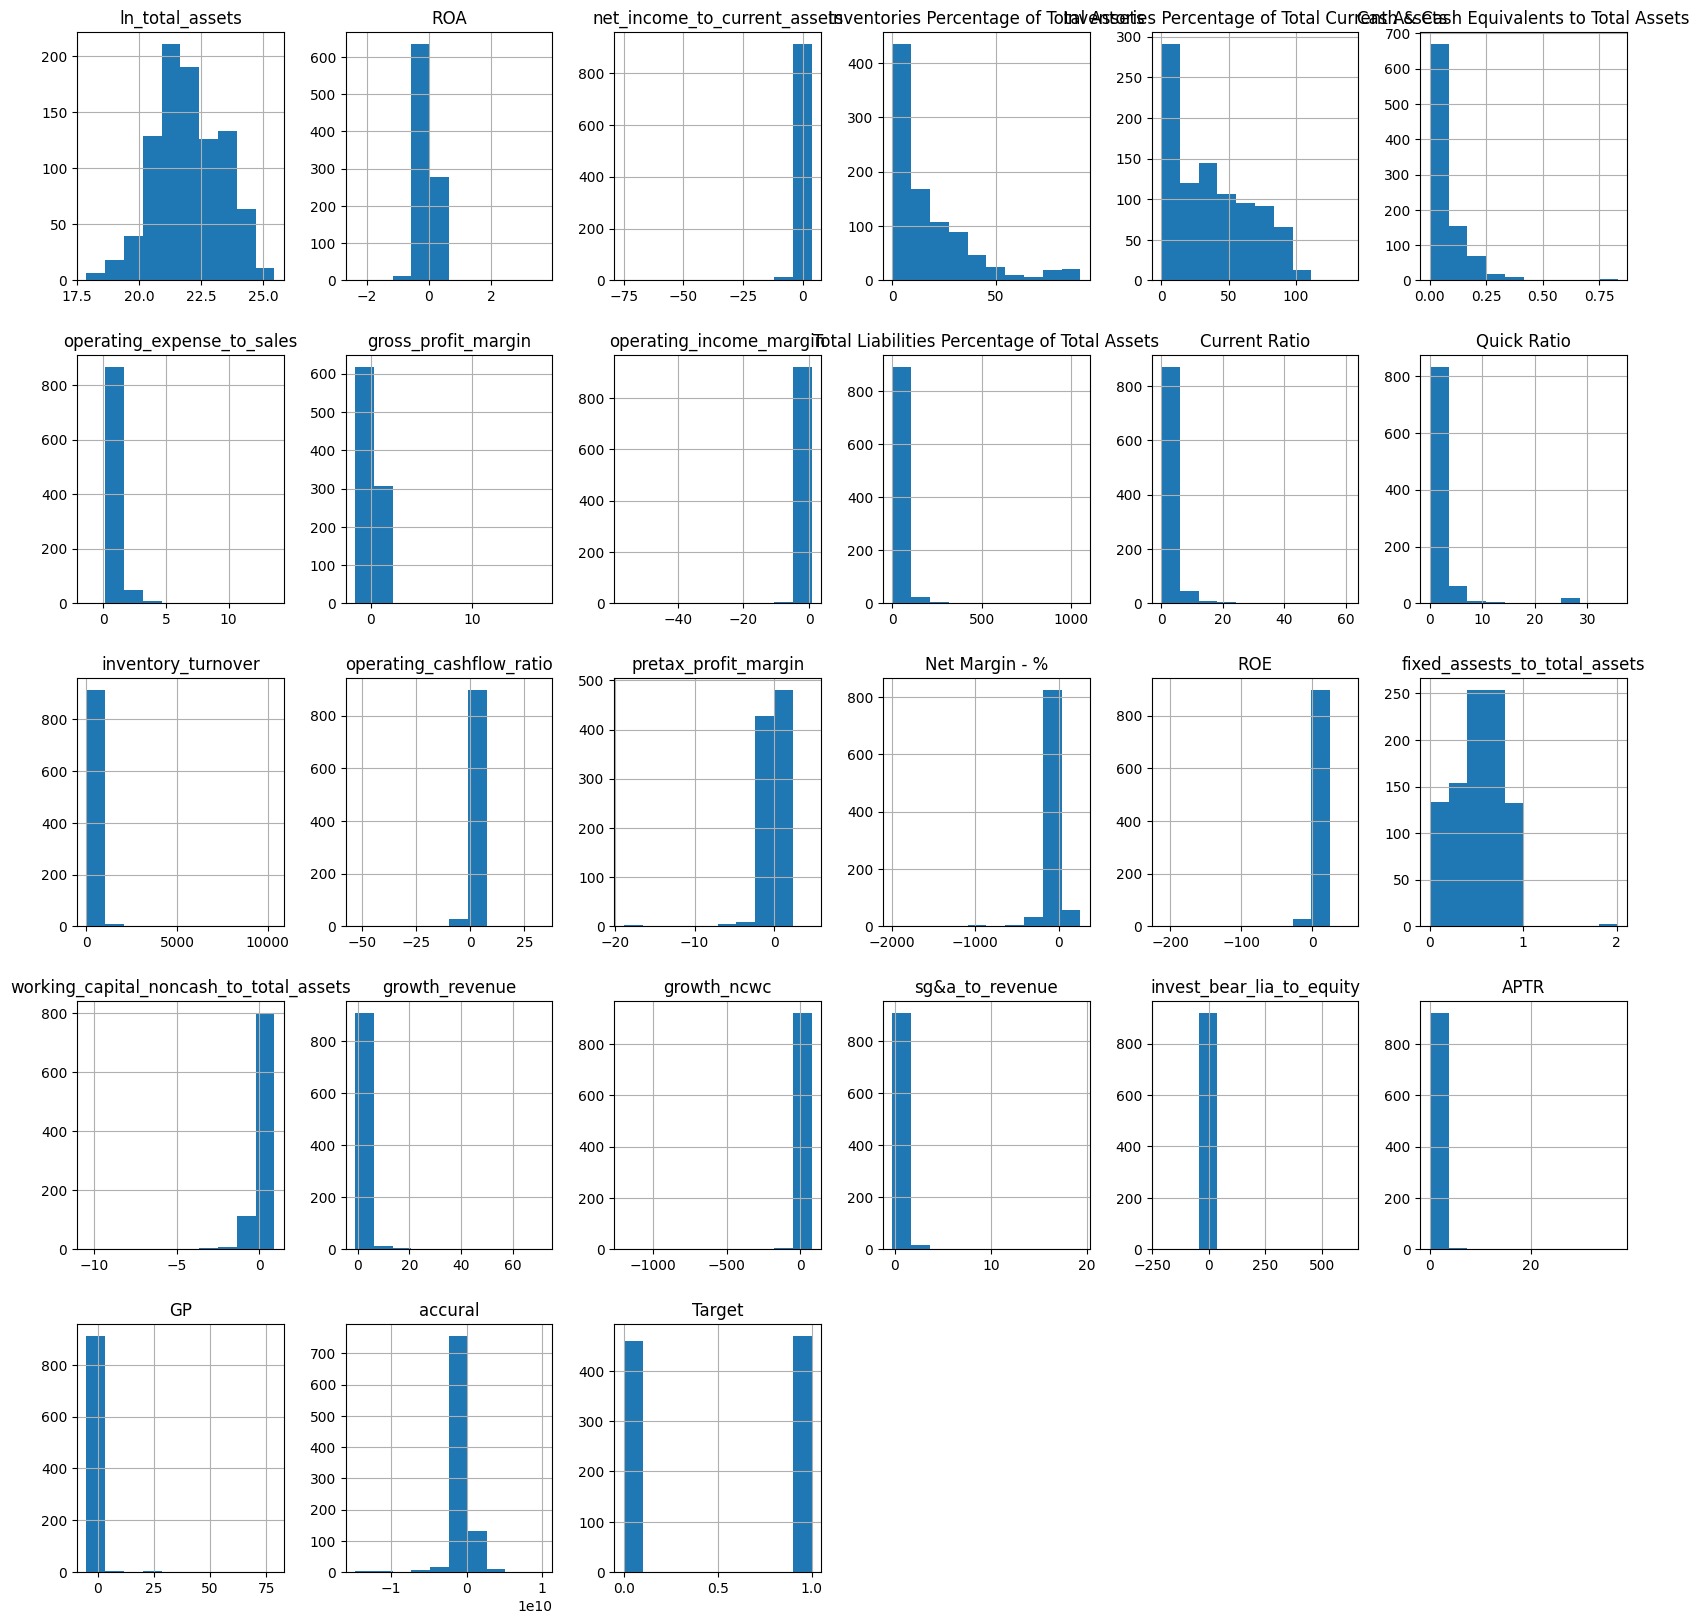

In [145]:
df2[num_cols].hist(layout=(5, 6), figsize=(20, 20))

/tmp/ipykernel_8933/1225860667.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df_long, x = 'Target', y='Value',


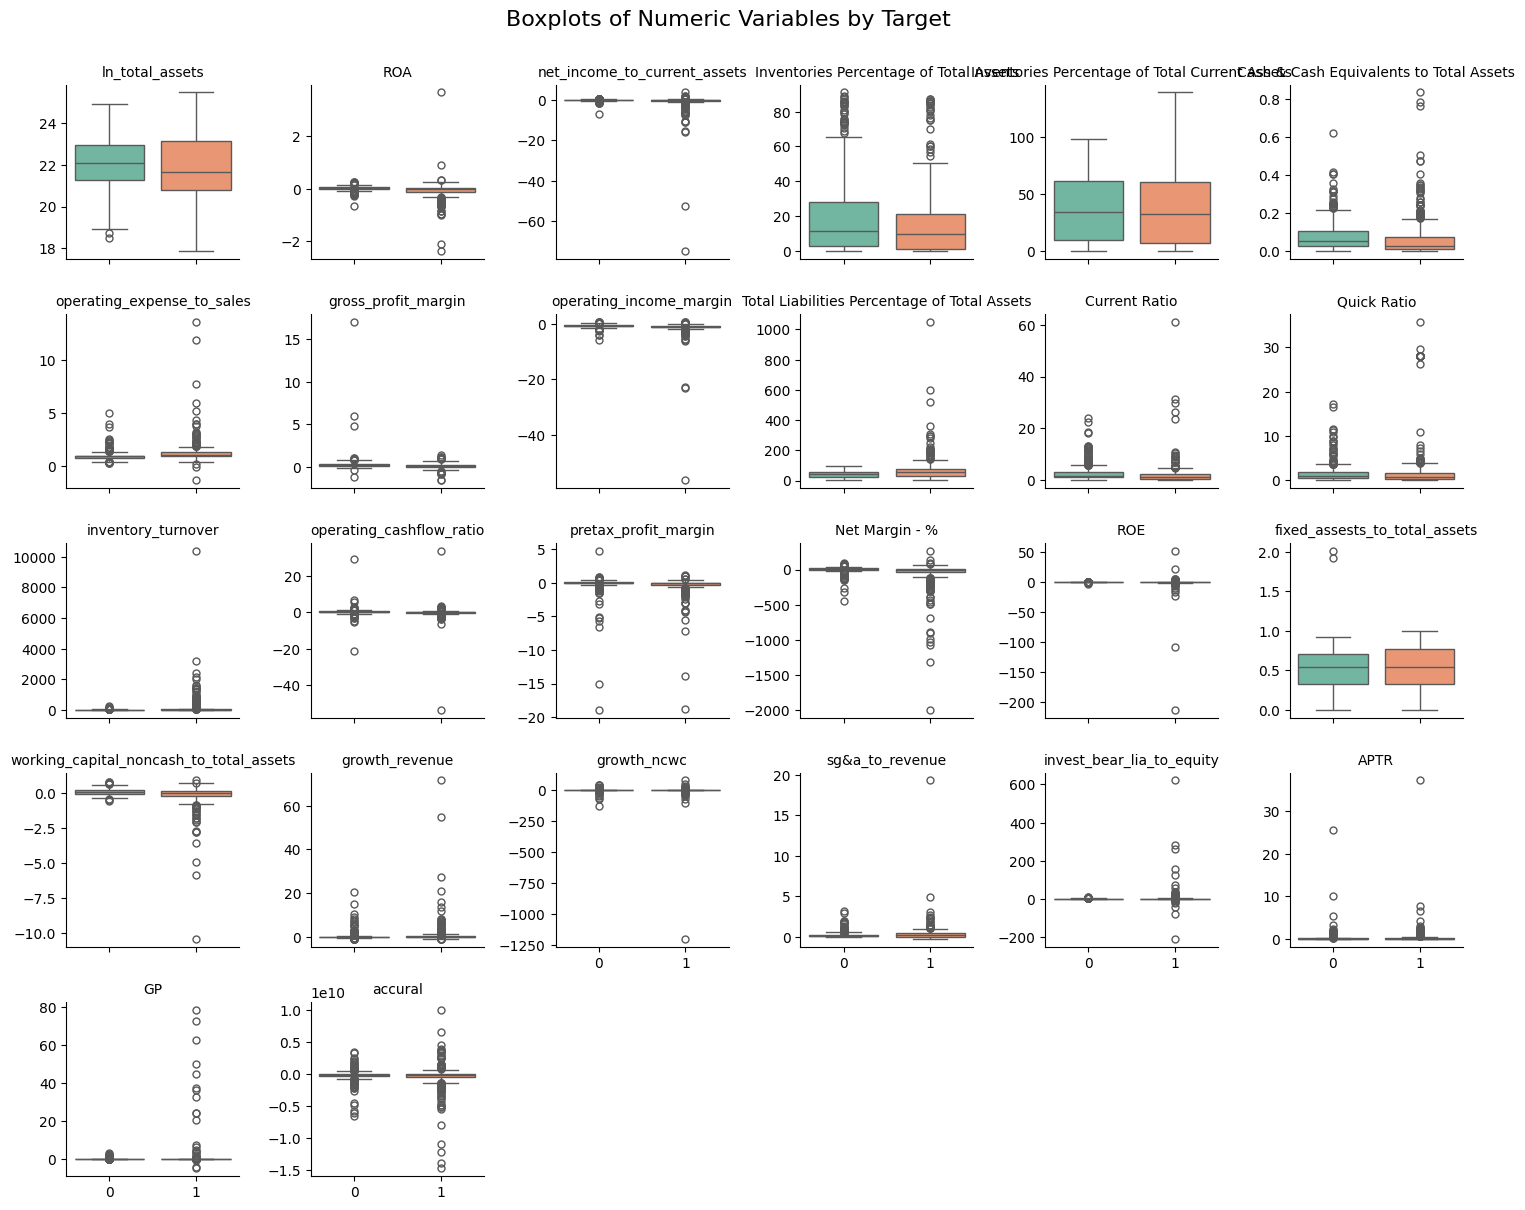

In [146]:
df_long = df2.melt(id_vars='Target',value_vars=num_cols,var_name='Variable',value_name='Value')

g = sns.catplot(data=df_long, x = 'Target', y='Value',
                col='Variable', kind='box', col_wrap=6,
                sharey=False, height=2.5, aspect=1, palette='Set2')

g.set_titles('{col_name}')
g.figure.subplots_adjust(top=0.92)
g.figure.suptitle('Boxplots of Numeric Variables by Target', fontsize=16)
for ax in g.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

In [147]:
# dcorr = df2[cols].corr()
# mask = np.zeros_like(dcorr)
# mask[np.triu_indices_from(mask)] = True

# fig, ax = plt.subplots(figsize=(24,20))
# sns.heatmap(dcorr, cmap=sns.diverging_palette(220, 20, as_cmap=True),
#             vmin=-1, vmax=1, center=0, linewidths=1, annot=True, 
#             mask=mask, ax=ax, annot_kws={"fontsize":6})

In [148]:
# sns.set_context("notebook", font_scale=1.4)
# plt.figure(figsize=(20, 20), dpi=150)
# g = sns.pairplot(df2, vars=cols,
#                  hue="Target", markers=['o','D','+'],
#                  plot_kws={'alpha': .6, 's': 30}, height=2.5, aspect=1.1)
# plt.tight_layout()
# plt.show()

# T-distrubution

In [149]:
df2[num_cols].groupby("Target").agg(["mean", "std"])

ln_total_assets                 ROA            \
                  mean       std      mean       std   
Target                                                 
0            22.131152  1.179416  0.030355  0.075863   
1            21.860366  1.450143 -0.056258  0.285549   

       net_income_to_current_assets            \
                               mean       std   
Target                                          
0                          0.070069  0.392385   
1                         -0.698694  4.519477   

       Inventories Percentage of Total Assets             \
                                         mean        std   
Target                                                     
0                                   19.120277  21.108784   
1                                   15.822089  19.053243   

       Inventories Percentage of Total Current Assets             ...  \
                                                 mean        std  ...   
Target                                                            ...   
0                                           37.122456  29.100033  ...   
1                                           36.309458  30.514103  ...   

       sg&a_to_revenue           invest_bear_lia_to_equity             \
                  mean       std                      mean        std   
Target                                                                  
0             0.261195  0.333516                  0.832756   1.085366   
1             0.391064  0.988591                  4.435789  36.806793   

            APTR                  GP                 accural                
            mean       std      mean       std          mean           std  
Target                                                                      
0       0.264563  1.333490  0.070372  0.270939 -1.526274e+08  8.008213e+08  
1       0.383359  1.829324  1.119923  7.283224 -3.111586e+08  1.715894e+09  

[2 rows x 52 columns]

In [150]:
results = []

for feat in df2[num_cols].columns:
    if feat == 'Target':
        continue
    # แยกกลุ่มตาม Target
    tmp = df2[num_cols][[feat, "Target"]].dropna()
    g0 = df2[num_cols].loc[df2[num_cols]['Target'] == 0, feat]
    g1 = df2[num_cols].loc[df2[num_cols]['Target'] == 1, feat]

    # คำนวณ mean และ std
    m0, s0 = g0.mean(), g0.std()
    m1, s1 = g1.mean(), g1.std()

    # t-test แบบ Welch
    t_stat, p_t = ttest_ind(g0, g1, equal_var=False)
    
    # t-stat test
    sig_t = p_t < 0.05

    results.append({'feature'         : feat,
                    'mean_0'          : m0,
                    'mean_1'          : m1,
                    'std_0'           : s0,
                    'std_1'           : s1,
                    't-statistic'     : t_stat,
                    't_pvalue'        : p_t,
                    'sig_t_0.05'      : sig_t,})

# สร้าง DataFrame สรุป
stats_df = pd.DataFrame(results).set_index('feature')

# แสดงผล
stats_df


,mean_0,mean_1,std_0,std_1,t-statistic,t_pvalue,sig_t_0.05
feature,,,,,,,
ln_total_assets,2.213115e+01,2.186037e+01,1.179416e+00,1.450143e+00,3.125754,1.830542e-03,True
ROA,3.035467e-02,-5.625845e-02,7.586314e-02,2.855492e-01,6.350364,4.583413e-10,True
net_income_to_current_assets,7.006914e-02,-6.986941e-01,3.923846e-01,4.519477e+00,3.673531,2.663648e-04,True
Inventories Percentage of Total Assets,1.912028e+01,1.582209e+01,2.110878e+01,1.905324e+01,2.498082,1.266171e-02,True
Inventories Percentage of Total Current Assets,3.712246e+01,3.630946e+01,2.910003e+01,3.051410e+01,0.415640,6.777696e-01,False
Cash & Cash Equivalents to Total Assets,7.708416e-02,6.233544e-02,7.580512e-02,9.814442e-02,2.566889,1.042574e-02,True
operating_expense_to_sales,9.280542e-01,1.214661e+00,3.922690e-01,1.006858e+00,-5.741116,1.482591e-08,True
gross_profit_margin,3.163421e-01,1.323833e-01,8.809030e-01,2.609487e-01,4.293823,2.084955e-05,True
operating_income_margin,-6.130092e-01,-1.167245e+00,5.623021e-01,3.018146e+00,3.912187,1.040538e-04,True


## Significant Features

In [151]:
sig_features = stats_df[stats_df['sig_t_0.05']].index.tolist()
sig_features


['ln_total_assets',
 'ROA',
 'net_income_to_current_assets',
 'Inventories Percentage of Total Assets',
 'Cash & Cash Equivalents to Total Assets',
 'operating_expense_to_sales',
 'gross_profit_margin',
 'operating_income_margin',
 'Total Liabilities Percentage of Total Assets',
 'Current Ratio',
 'Quick Ratio',
 'inventory_turnover',
 'pretax_profit_margin',
 'Net Margin - %',
 'working_capital_noncash_to_total_assets',
 'growth_revenue',
 'sg&a_to_revenue',
 'invest_bear_lia_to_equity',
 'GP']

# ML selected

#### train test split

In [152]:
X_raw = df2[cols].values        # ดิบยังไม่ scale  
y     = df2['Target'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)


In [153]:
print("Train fraud (y=1):", np.sum(y_train == 1))
print("Train non-fraud (y=0):", np.sum(y_train == 0))
print("Test fraud (y=1):", np.sum(y_test == 1))
print("Test non-fraud (y=0):", np.sum(y_test == 0))

Train fraud (y=1): 376
Train non-fraud (y=0): 367
Test fraud (y=1): 94
Test non-fraud (y=0): 92


In [154]:
Z_scaler = StandardScaler()
X_train_std = Z_scaler.fit_transform(X_train_raw)
X_test_std  = Z_scaler.transform(X_test_raw)

rb_scaler = RobustScaler()
X_train_rb = rb_scaler.fit_transform(X_train_raw)
X_test_rb  = rb_scaler.transform(X_test_raw)

X_train_wins = winsorize(X_train_rb, limits=[0.05, 0.05], axis=0)
X_test_wins  = winsorize(X_test_rb, limits=[0.05, 0.05], axis=0)

#### Ditribution each method

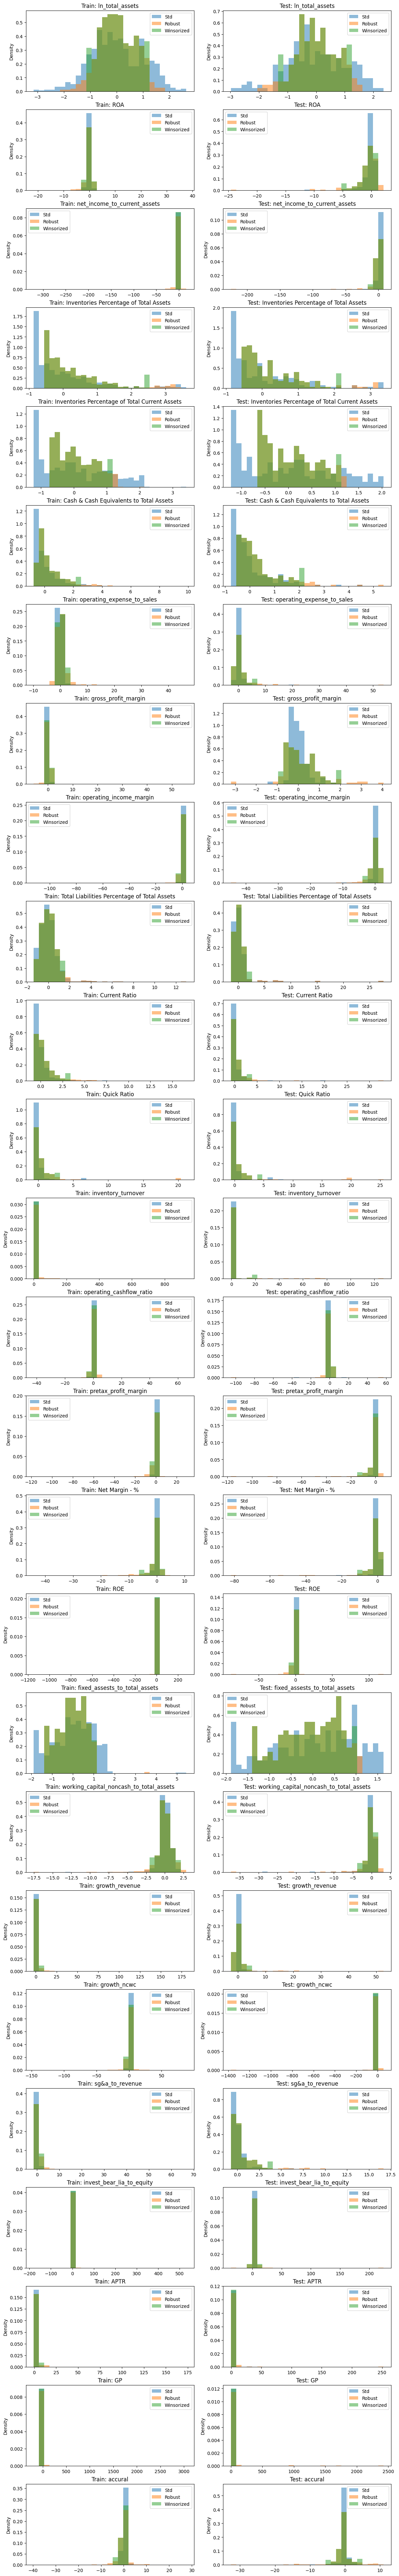

In [155]:
n_feat = len(cols)
fig, axes = plt.subplots(n_feat, 2, figsize=(12, 3 * n_feat), constrained_layout=True)

for i, col in enumerate(cols):
    # Train
    all_train = np.concatenate([X_train_std[:,i], X_train_rb[:,i], X_train_wins[:,i]])
    bins_train = np.linspace(all_train.min(), all_train.max(), 30)
    ax_train = axes[i, 0]
    ax_train.hist(X_train_std[:, i], bins=bins_train, alpha=0.5, label="Std", density=True)
    ax_train.hist(X_train_rb[:,  i], bins=bins_train, alpha=0.5, label="Robust", density=True)
    ax_train.hist(X_train_wins[:, i], bins=bins_train, alpha=0.5, label="Winsorized", density=True)
    ax_train.set_title(f"Train: {col}")
    ax_train.set_ylabel("Density")
    ax_train.legend()

    # Test
    all_test = np.concatenate([X_test_std[:,i], X_test_rb[:,i], X_test_wins[:,i]])
    bins_test = np.linspace(all_test.min(), all_test.max(), 30)
    ax_test = axes[i, 1]
    ax_test.hist(X_test_std[:, i], bins=bins_test, alpha=0.5, label="Std", density=True)
    ax_test.hist(X_test_rb[:,  i], bins=bins_test, alpha=0.5, label="Robust", density=True)
    ax_test.hist(X_test_wins[:, i], bins=bins_test, alpha=0.5, label="Winsorized", density=True)
    ax_test.set_title(f"Test: {col}")
    ax_test.set_ylabel("Density")
    ax_test.legend()

plt.show()

In [156]:
datasets = [("Standardized", X_train_std, X_test_std),
           ("Robust Scaled", X_train_rb, X_test_rb),
           ("Winsorized", X_train_wins, X_test_wins)]


for name, X_train, X_test in datasets:
    model = Sequential([Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
                        Dense(32, activation="relu"),
                        Dense(1, activation="sigmoid")])
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, batch_size=32,
            callbacks=[es],verbose=0)

    y_pred = model.predict(X_test).ravel()
    y_pred_class = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred)

    print(f"{name:8s} -> Accuracy: {acc:.4f}, AUC: {auc:.4f}") ## เดี๋ยวค่อยทำ plot

/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Standardized -> Accuracy: 0.8495, AUC: 0.9133


/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Robust Scaled -> Accuracy: 0.8226, AUC: 0.8895


/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Winsorized -> Accuracy: 0.8280, AUC: 0.8877


#### Train test split

In [157]:
X_tr = X_train_std.copy()
y_tr = y_train.copy()
X_te = X_test_std.copy()
y_te = y_test.copy()

# sm = SMOTE(random_state=42, sampling_strategy='auto')

# X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# print("Before SMOTE:", np.bincount(y_tr))
# print("After  SMOTE:", np.bincount(y_tr_res))

### Build ANN for Keras

In [158]:
def build_model(hp):
    model = Sequential()
    n_layers = hp.Int("n_layers", 1, 2, 3)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", 10, 300, step=29)
        l2_val = hp.Float(f"l2_{i}", 1e-6, 1e-3, sampling="log")
        dropout_val = hp.Float(f"dropout_{i}", 0, 0.6, step=0.1)
        model.add(Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_val),
                        input_shape=(X_tr.shape[1],) if i==0 else None))
        model.add(Dropout(dropout_val))
    model.add(Dense(1, activation="sigmoid"))
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")])
    return model


### Setting and turning by Keras tuner

In [159]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_auc",
    max_trials=20,
    executions_per_trial=1,
    directory="my_dir",
    project_name="ann_tuning")

earlystop = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)

tuner.search(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=50,
    batch_size=32,
    callbacks=[earlystop],
    verbose=1)


Reloading Tuner from my_dir/ann_tuning/tuner0.json


### Get the best hyperparesmeters

In [160]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for i in range(best_hps.get("n_layers")):
    print(f" Layer {i}: units={best_hps.get(f'units_{i}')}, l2={best_hps.get(f'l2_{i}')}, dropout={best_hps.get(f'dropout_{i}')}")
print("Learning rate:", best_hps.get("learning_rate"))


Best hyperparameters found:
 Layer 0: units=192, l2=5.255465965190712e-05, dropout=0.30000000000000004
 Layer 1: units=224, l2=7.982505837449515e-05, dropout=0.2
 Layer 2: units=96, l2=0.00029273824679725387, dropout=0.30000000000000004
Learning rate: 0.0011151917296659004


### Build new model with best hyperparameters and train

In [161]:
def build_best_model(best_hps):
    model = Sequential()
    n_layers = best_hps.get("n_layers")
    for i in range(n_layers):
        units = best_hps.get(f"units_{i}")
        l2_val = best_hps.get(f"l2_{i}")
        dropout_val = best_hps.get(f"dropout_{i}")
        model.add(Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_val),
                        input_shape=(X_tr.shape[1],) if i==0 else None))
        model.add(Dropout(dropout_val))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate")),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")])
    return model

model = build_best_model(best_hps)
es = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)
history = model.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1)


Epoch 1/100


/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - auc: 0.4953 - loss: 0.7720 - val_auc: 0.7722 - val_loss: 0.6836
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6775 - loss: 0.6981 - val_auc: 0.7995 - val_loss: 0.6313
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7432 - loss: 0.6503 - val_auc: 0.8272 - val_loss: 0.5892
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7526 - loss: 0.6258 - val_auc: 0.8530 - val_loss: 0.5589
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8165 - loss: 0.5828 - val_auc: 0.8595 - val_loss: 0.5462
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8239 - loss: 0.5635 - val_auc: 0.8789 - val_loss: 0.5062
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8602 - loss: 0.5370 - val_auc: 0.8742 - val_loss: 0.5052
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8545 - loss: 0.5286 - val_auc: 0.8861 - val_loss: 0.4886
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8790 - l

In [162]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 192)            │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 224)            │        43,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 96)             │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,341 (821.65 KB)

 Trainable params: 70,113 (273.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 140,228 (547.77 KB)

In [163]:
hidden1 = model.layers[0]
weights, biases = hidden1.get_weights()

print("Weights shape:", weights.shape)
print("Weights :\n", weights)
print("Biases shape:", biases.shape)
print("Biases:\n", biases)

Weights shape: (26, 192)
Weights :
 [[-0.03639783 -0.14421688 -0.11465865 ...  0.11362381 -0.05586834
  -0.0916947 ]
 [ 0.13298409 -0.21575369 -0.15489471 ...  0.11960629  0.08686393
  -0.04456971]
 [-0.11263927 -0.04335535 -0.07770819 ... -0.21282965  0.02243811
  -0.1286896 ]
 ...
 [ 0.13057147  0.04824096 -0.18590286 ... -0.04760333  0.01045923
   0.12816212]
 [-0.01622012 -0.05835729 -0.00320017 ... -0.10996322 -0.01460143
   0.1685056 ]
 [ 0.13565502  0.01419408  0.01463252 ... -0.13188386 -0.0019229
  -0.10595265]]
Biases shape: (192,)
Biases:
 [ 0.02032887  0.05844733  0.01986291  0.02358176 -0.0213015   0.03400152
 -0.00830808 -0.00013315 -0.03019568 -0.09637242 -0.01396025 -0.02626154
 -0.02653624 -0.01837505  0.01371492  0.04926977  0.02124056 -0.05127052
  0.01390121  0.0078301  -0.00169973  0.01516919  0.03542256 -0.03828014
 -0.04504621 -0.03138696 -0.02926902 -0.07650319 -0.00573477 -0.01530077
 -0.07530252 -0.04021103  0.02179819 -0.06394605 -0.0634435  -0.03127902
 -0.0

### Evaluate performance

In [164]:
def evaluate_model(model, X, y, set_name="Test"):
    prob = model.predict(X).ravel()
    pred = (prob > 0.5).astype(int)
    print(f"\n=== {set_name} Set Results ===")
    print("Accuracy:", accuracy_score(y, pred))
    print("AUC:     ", roc_auc_score(y, prob))
    print("Confusion Matrix:\n", confusion_matrix(y, pred))
    print("Classification Report:\n", classification_report(y, pred))

evaluate_model(model, X_te, y_te, "Test")
evaluate_model(model, X_tr, y_tr, "Training")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

=== Test Set Results ===
Accuracy: 0.8387096774193549
AUC:      0.9077243293246994
Confusion Matrix:
 [[76 16]
 [14 80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84        92
           1       0.83      0.85      0.84        94

    accuracy                           0.84       186
   macro avg       0.84      0.84      0.84       186
weighted avg       0.84      0.84      0.84       186

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Training Set Results ===
Accuracy: 0.9125168236877523
AUC:      0.9714258797611456
Confusion Matrix:
 [[344  23]
 [ 42 334]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       367
           1       0.94      0.89      0.91       376

    accuracy                           0.91       743
   macro avg       0.91      0.91      0.91       743
weighted avg       0.91

### Plot learning curve

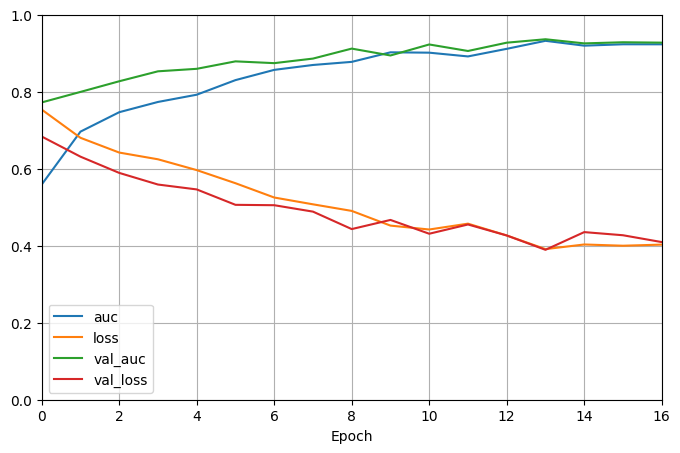

In [165]:
pd.DataFrame(history.history).plot(figsize=(8,5),
                                   xlim=[0,16], ylim=[0,1], grid=True, xlabel="Epoch")
plt.show()

### feature important by ANN

In [166]:
X_tr_df = pd.DataFrame(X_tr, columns=cols)
X_te_df = pd.DataFrame(X_te, columns=cols)

background = X_tr_df.sample(n=100, random_state=42) if len(X_tr) > 100 else X_tr
explainer = shap.Explainer(model, background)
shap_values = explainer(X_te_df)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feat_imp_shap = pd.DataFrame({
    'feature': X_te_df.columns,
    'mean_abs_shap': mean_abs_shap}).sort_values('mean_abs_shap', ascending=False)

feat_imp_shap

PermutationExplainer explainer: 187it [00:37,  3.80it/s]                         


,feature,mean_abs_shap
9,Total Liabilities Percentage of Total Assets,0.075458
15,Net Margin - %,0.065045
0,ln_total_assets,0.056429
6,operating_expense_to_sales,0.054662
1,ROA,0.049309
11,Quick Ratio,0.044937
18,working_capital_noncash_to_total_assets,0.041745
14,pretax_profit_margin,0.040241
7,gross_profit_margin,0.038600
5,Cash & Cash Equivalents to Total Assets,0.037891


# Compare features from t-stat and ML

In [167]:
df_compare = pd.DataFrame({'ANN Features important': pd.Series(feat_imp_shap['feature'].tolist()),
                           'Significant t-test Features': pd.Series(sig_features)})

df_compare

,ANN Features important,Significant t-test Features
0,Total Liabilities Percentage of Total Assets,ln_total_assets
1,Net Margin - %,ROA
2,ln_total_assets,net_income_to_current_assets
3,operating_expense_to_sales,Inventories Percentage of Total Assets
4,ROA,Cash & Cash Equivalents to Total Assets
5,Quick Ratio,operating_expense_to_sales
6,working_capital_noncash_to_total_assets,gross_profit_margin
7,pretax_profit_margin,operating_income_margin
8,gross_profit_margin,Total Liabilities Percentage of Total Assets
9,Cash & Cash Equivalents to Total Assets,Current Ratio


# Models

## Prepare Data and Feature Selection

In [168]:
ten_features = feat_imp_shap["feature"].tolist()[:10]  # Select top 10 features
X_train_sel = pd.DataFrame(X_tr, columns=feat_imp_shap["feature"].tolist())  # Use all features for now
X_train_sel = X_train_sel[ten_features]  # Select only top 10
X_test_sel = pd.DataFrame(X_te, columns=feat_imp_shap["feature"].tolist())
X_test_sel = X_test_sel[ten_features]

print("Top 10 features ANN:", ten_features)
print("X_train_sel shape:", X_train_sel.shape)
print("X_test_sel shape:", X_test_sel.shape)

Top 10 features ANN: ['Total Liabilities Percentage of Total Assets', 'Net Margin - %', 'ln_total_assets', 'operating_expense_to_sales', 'ROA', 'Quick Ratio', 'working_capital_noncash_to_total_assets', 'pretax_profit_margin', 'gross_profit_margin', 'Cash & Cash Equivalents to Total Assets']
X_train_sel shape: (743, 10)
X_test_sel shape: (186, 10)


#### Random Forest + GridSearchCV

In [169]:
from sklearn.ensemble    import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [170]:
# rf = RandomForestClassifier(random_state=42)
# param_grid_rf = {"n_estimators":      [100, 300, 500],
#                  "max_depth":         [5, 10, 20, None],
#                  "max_features":      ["sqrt", "log2", 15, 26],
#                  "min_samples_split": [2, 5, 10],
#                  "min_samples_leaf":  [1, 5, 10],
#                  "criterion":         ["gini", "entropy"]}

# grid_rf = GridSearchCV(rf, param_grid_rf, scoring="roc_auc", cv=5, n_jobs=-1)

# grid_rf.fit(X_train_sel, y_tr)

# print("RF best params: ", grid_rf.best_params_)
# print("RF CV AUC:     ", grid_rf.best_score_)
# y_rf_prob = grid_rf.predict_proba(X_test_sel)[:, 1]
# print("RF Test AUC:   ", roc_auc_score(y_te, y_rf_prob))

# y_rf_pred = grid_rf.predict(X_test_sel)

# print("RF Results:")
# print("Accuracy:           ", accuracy_score(y_te, y_rf_pred))
# print("ROC-AUC:            ", roc_auc_score(y_te, y_rf_prob))
# print("Confusion Matrix:\n", confusion_matrix(y_te, y_rf_pred))
# print("Classification Report:\n", classification_report(y_te, y_rf_pred))

In [171]:
# best_rf = grid_rf.best_estimator_
# # Feature importances from Random Forest
# feat_imp_rf = pd.DataFrame({"feature": X_train_sel.columns,
#                             "importance": best_rf.feature_importances_})
# feat_imp_rf = feat_imp_rf.sort_values("importance", ascending=False)
# feat_imp_rf

## Logistic Regression + GridSearchCV

In [172]:
from sklearn.linear_model  import LogisticRegression

In [173]:
# pipe_lr = LogisticRegression(random_state=42)
# param_grid_lr = [
#     {"C":       np.logspace(-4, 4, 20),
#      "penalty": ["l1"],
#      "solver":  ["liblinear", "saga"],
#      "max_iter": [100, 1000, 2000, 5000]},
     
#     {"C":       np.logspace(-4, 4, 20),
#      "penalty": ["l2"],
#      "solver":  ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],
#      "max_iter": [100, 1000, 2000, 5000]},

#     {"C":       np.logspace(-4, 4, 20),
#      "penalty": ["elasticnet"],
#      "solver":  ["saga"],
#      "max_iter": [100, 1000, 2000, 5000],
#      "l1_ratio": [0.1, 0.5, 0.9]},

#     {"C":       np.logspace(-4, 4, 20),
#      "penalty": ["none"],
#      "solver":  ["lbfgs", "newton-cg", "sag", "saga"],
#      "max_iter": [100, 1000, 2000, 5000]}]

# grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring="roc_auc", cv=5, n_jobs=-1)

# grid_lr.fit(X_train_sel, y_tr)

# print("LR best params: ", grid_lr.best_estimator_)
# print("LR CV AUC:     ", grid_lr.best_score_)
# y_lr_prob = grid_lr.predict_proba(X_test_sel)[:, 1]
# print("LR Test AUC:   ", roc_auc_score(y_te, y_lr_prob))

# y_lr_pred = grid_lr.predict(X_test_sel)
# print("LR Results:")
# print("Accuracy:", accuracy_score(y_te, y_lr_pred))
# print("ROC-AUC:", roc_auc_score(y_te, y_lr_prob))
# print("Confusion Matrix:\n", confusion_matrix(y_te, y_lr_pred))
# print("Classification Report:\n", classification_report(y_te, y_lr_pred))

In [174]:
# best_lr = grid_lr.best_estimator_
# # Feature importances from Logistic Regression
# feat_imp_lr = pd.DataFrame({"feature": X_train_sel.columns,
#                             "importance": np.abs(best_lr.coef_[0])})
# feat_imp_lr = feat_imp_lr.sort_values("importance", ascending=False)
# feat_imp_lr

## SVM + GridSearchCV

In [175]:
from sklearn.svm import SVC

In [176]:
# svc = SVC(probability=True, random_state=42)
# param_grid_svc = [
#     {"C":      [0.1, 1, 10, 100, 1000],
#      "kernel": ["linear"]},

#     {"C":      [0.1, 1, 10, 100, 1000],
#      "kernel": ["rbf"],
#      "gamma":  ["scale", 1, 0.1, 0.01, 0.001]},
     
#      {"C":      [0.1, 1, 10, 100, 1000],
#      "kernel":  ["poly"],
#      "gamma":   ["scale", 1, 0.1, 0.01, 0.001],
#      "degree":  [2, 3, 4]}]

# grid_svc = GridSearchCV(svc, param_grid_svc, scoring="roc_auc", cv=5, n_jobs=-1)

# grid_svc.fit(X_train_sel, y_tr)

# print("SVC best params:", grid_svc.best_params_)
# print("SVC CV AUC:    ", grid_svc.best_score_)
# y_svc_prob = grid_svc.predict_proba(X_test_sel)[:, 1]
# print("SVC Test AUC:  ", roc_auc_score(y_te, y_svc_prob))

# y_svc_pred = grid_svc.predict(X_test_sel)
# print("SVC Results:")
# print("Accuracy:", accuracy_score(y_te, y_svc_pred))
# print("ROC-AUC:", roc_auc_score(y_te, y_svc_prob))
# print("Confusion Matrix:\n", confusion_matrix(y_te, y_svc_pred))
# print("Classification Report:\n", classification_report(y_te, y_svc_pred))

In [177]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     grid_svc.best_estimator_, X_test_sel, y_te,
#     n_repeats=10, random_state=42, n_jobs=-1)

# feat_imp_svc = pd.DataFrame({
#     "feature": X_test_sel.columns,
#     "importance": result.importances_mean}).sort_values("importance", ascending=False)
# feat_imp_svc

## XGBoost + GridSearchCV

In [178]:
import xgboost as xgb

In [179]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid_xgb = {"max_depth":        [3, 5, 7, 9, 11],
                  "n_estimators":     [100, 300, 500],
                  "learning_rate":    [0.01, 0.1, 1],
                  "subsample":        [0.6, 0.8, 1],
                  "min_child_weight": [1, 3, 5],
                  "colsample_bytree": [0.5, 0.8, 1]}

grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring="roc_auc", cv=5, n_jobs=-1)

grid_xgb.fit(X_train_sel, y_tr)

print("XGB best params:", grid_xgb.best_params_)
print("XGB CV AUC:    ", grid_xgb.best_score_)
y_xgb_prob = grid_xgb.predict_proba(X_test_sel)[:, 1]
print("XGB Test AUC:  ", roc_auc_score(y_te, y_xgb_prob))

y_xgb_pred = grid_xgb.predict(X_test_sel)
print("XGB Results:")
print("Accuracy:", accuracy_score(y_te, y_xgb_pred))
print("ROC-AUC:", roc_auc_score(y_te, y_xgb_prob))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_xgb_pred))
print("Classification Report:\n", classification_report(y_te, y_xgb_pred))

/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

XGB best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
XGB CV AUC:     0.9428901316601388
XGB Test AUC:   0.939176688251619
XGB Results:
Accuracy: 0.8655913978494624
ROC-AUC: 0.939176688251619
Confusion Matrix:
 [[77 15]
 [10 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86        92
           1       0.85      0.89      0.87        94

    accuracy                           0.87       186
   macro avg       0.87      0.87      0.87       186
weighted avg       0.87      0.87      0.87       186



In [194]:
best_xgb = grid_xgb.best_estimator_
# Feature importances from XGBoost
feat_imp_xgb = pd.DataFrame({"feature": X_train_sel.columns,
                             "importance": best_xgb.feature_importances_})
feat_imp_xgb = feat_imp_xgb.sort_values("importance", ascending=False)
feat_imp_xgb

,feature,importance
2,ln_total_assets,0.160996
6,working_capital_noncash_to_total_assets,0.115363
0,Total Liabilities Percentage of Total Assets,0.114318
1,Net Margin - %,0.106252
8,gross_profit_margin,0.105451
5,Quick Ratio,0.098076
3,operating_expense_to_sales,0.085804
7,pretax_profit_margin,0.081817
4,ROA,0.070582
9,Cash & Cash Equivalents to Total Assets,0.061341


In [195]:
# results = []
# models = {
#     "Random Forest":       (grid_rf,  y_rf_prob),
#     "Logistic Regression": (grid_lr,  y_lr_prob),
#     "SVM":                 (grid_svc, y_svc_prob),
#     "XGBoost":             (grid_xgb, y_xgb_prob)}

# for name, (grid, y_prob) in models.items():
#     y_pred = grid.predict(X_test_sel)
#     results.append({
#         "Model":    name,
#         "Accuracy": accuracy_score(y_te, y_pred),
#         "ROC-AUC":  roc_auc_score(y_te, y_prob),
#         "precision": precision_score(y_te, y_pred)})
  


# comparison_df = pd.DataFrame(results).set_index("Model")
# print(comparison_df)

In [196]:
# feats = {
#     "RF":  feat_imp_rf.sort_values("importance", ascending=False).reset_index(drop=True),
#     "LR":  feat_imp_lr.sort_values("importance", ascending=False).reset_index(drop=True),
#     "SVM": feat_imp_svc.sort_values("importance", ascending=False).reset_index(drop=True),
#     "XGB": feat_imp_xgb.sort_values("importance", ascending=False).reset_index(drop=True)
# }
# comparison_feats = pd.concat(feats, axis=1)
# comparison_feats

In [197]:
from sklearn.metrics import roc_curve, auc

In [198]:
# fpr_rf,  tpr_rf,  _ = roc_curve(y_te, y_rf_prob)
# fpr_lr,  tpr_lr,  _ = roc_curve(y_te, y_lr_prob)
# fpr_svc, tpr_svc, _ = roc_curve(y_te, y_svc_prob)
# fpr_xgb, tpr_xgb, _ = roc_curve(y_te, y_xgb_prob)

# auc_rf  = auc(fpr_rf,  tpr_rf)
# auc_lr  = auc(fpr_lr,  tpr_lr)
# auc_svc = auc(fpr_svc, tpr_svc)
# auc_xgb = auc(fpr_xgb, tpr_xgb)

# plt.figure(figsize=(8,6))
# plt.plot(fpr_rf,  tpr_rf,  label=f"RandomForest (AUC={auc_rf:.3f})")
# plt.plot(fpr_lr,  tpr_lr,  label=f"LogisticReg  (AUC={auc_lr:.3f})")
# plt.plot(fpr_svc, tpr_svc, label=f"SVM (AUC={auc_svc:.3f})")
# plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")

# plt.plot([0,1],[0,1], 'k--', label="Random guess")

# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curves Comparison")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

####  What's next 
1. plot graph✅
2. tune overfit✅
3. why SMOTE? ไม่ใช้ละ
4. เริ่มเขียน method, result, lit->  31 Jul 14.00

In [212]:
a=3

# Addition

In [199]:
from pathlib import Path
import os
import joblib
from joblib import load
from sklearn.pipeline import Pipeline

In [200]:
path_save = "model"
model_name = "xgboost"

if not os.path.isdir("model"):
    print("create path model")
    os.mkdir(path_save)
else:
    print("model path is exist")

path_file = Path(path_save) / (model_name + ".joblib")
path_file

model path is exist


PosixPath('model/xgboost.joblib')

In [201]:
loaded_model, loaded_features = load(path_file)

In [202]:
loaded_features

['Total Liabilities Percentage of Total Assets',
 'Net Margin - %',
 'ln_total_assets',
 'operating_expense_to_sales',
 'ROA',
 'Quick Ratio',
 'working_capital_noncash_to_total_assets',
 'pretax_profit_margin',
 'gross_profit_margin',
 'Cash & Cash Equivalents to Total Assets']

In [203]:
X_train_sel_raw = pd.DataFrame(X_train_raw, columns=feat_imp_shap["feature"].tolist())
X_train_sel_raw = X_train_sel_raw[loaded_features]
X_train_sel_raw

,Total Liabilities Percentage of Total Assets,Net Margin - %,ln_total_assets,operating_expense_to_sales,ROA,Quick Ratio,working_capital_noncash_to_total_assets,pretax_profit_margin,gross_profit_margin,Cash & Cash Equivalents to Total Assets
0,19.685950,0.019531,0.123409,0.795679,7.429280,0.00245,0.959797,0.242478,-0.717319,113.99730
1,22.036556,-0.022446,-0.058097,0.095963,0.238461,0.03167,0.970178,0.000000,0.029822,45.06736
2,23.605838,-0.135578,-0.254703,46.975730,88.250700,0.01532,1.930397,0.396662,-1.533735,103.24301
3,23.569494,0.034056,0.096000,30.764500,86.721130,0.02218,0.739262,0.387627,-0.351635,56.12083
4,21.860035,-0.191880,-0.436011,17.458820,39.671950,0.02216,1.187140,-0.117341,-1.304481,52.64795
...,...,...,...,...,...,...,...,...,...,...
738,24.519438,0.085727,0.543622,0.287320,1.821960,0.10118,0.579696,0.477909,-0.101787,66.89090
739,24.387892,0.056921,0.305043,1.672010,8.960400,0.04099,0.604427,0.874834,-0.090495,70.97216
740,20.813455,0.050346,0.052951,26.449330,27.817580,0.01400,0.941093,0.352970,-0.588122,73.47708
741,21.260282,-0.025430,-0.070238,6.998300,19.329350,0.00775,0.975950,0.066221,-0.909729,72.46996


In [204]:
X_test_sel_raw = pd.DataFrame(X_test_raw, columns=feat_imp_shap["feature"].tolist())
X_test_sel_raw = X_test_sel_raw[loaded_features]
X_test_sel_raw

,Total Liabilities Percentage of Total Assets,Net Margin - %,ln_total_assets,operating_expense_to_sales,ROA,Quick Ratio,working_capital_noncash_to_total_assets,pretax_profit_margin,gross_profit_margin,Cash & Cash Equivalents to Total Assets
0,23.938665,-0.039344,-0.105329,27.767550,74.337740,0.03255,1.028405,-0.003621,-1.032027,39.33405
1,19.048719,-0.441820,-10.948691,1.869870,46.336950,0.00173,0.616927,1.058792,-0.087531,360.46277
2,22.039752,0.025839,0.069317,0.136020,0.364880,0.00958,0.745277,0.000000,0.254723,51.93313
3,22.218162,-0.034039,-0.166115,0.493080,2.406240,0.02320,1.435279,0.141403,-1.293876,25.08812
4,20.460996,0.089872,0.195779,8.805160,19.181370,0.13173,0.861059,0.437057,-0.424002,37.58294
...,...,...,...,...,...,...,...,...,...,...
181,23.378302,-0.371327,-0.566087,58.808500,89.653370,0.01725,3.118190,0.182247,-2.935943,141.23306
182,22.419433,0.043761,0.111977,8.935450,22.864090,0.20661,1.050650,0.197702,-0.852948,48.55165
183,21.915442,0.020630,0.053683,0.415156,2.436355,0.01639,0.728173,0.405356,-0.322817,35.12457
184,20.489799,-0.139405,-0.150668,0.070220,0.075890,0.25942,1.906769,0.000000,-1.734876,7.33925


In [205]:
pipeline_xgb = Pipeline([('scale', StandardScaler()),
                         ('xgb', grid_xgb.best_estimator_)])

pipeline_xgb.fit(X_train_sel_raw, y_tr)

/mnt/d/SAVER/Research/Repo/test/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('scale', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [206]:
joblib.dump((pipeline_xgb, ten_features), path_file)

['model/xgboost.joblib']

## Test model loaded

In [208]:
loaded_model.predict(X_test_sel_raw)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cash & Cash Equivalents to Total Assets
- Quick Ratio
- pretax_profit_margin
Feature names seen at fit time, yet now missing:
- accural
- fixed_assests_to_total_assets
- inventory_turnover
